Этот код содержит реализацию VIT из этой [статьи](https://arxiv.org/abs/2010.11929).

## Setup

In [1]:
import torch
import torchvision
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import pickle
import torch.autograd as autograd
from  sklearn.model_selection import train_test_split
from sklearn.feature_extraction import image
import tensorflow as tf

from torch.utils.tensorboard import SummaryWriter
from typing import Tuple, List, Type, Dict, Any
from os.path import join, isfile, isdir
from queue import Empty, Queue
from threading import Thread

# augmentation library
from imgaug.augmentables import Keypoint, KeypointsOnImage
import imgaug.augmenters as iaa 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Connect CUDA

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Проверим доступность GPU
torch.cuda.device_count()
if torch.cuda.is_available() :
  print(torch.cuda.get_device_properties(DEVICE))

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [5]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Prepare the data ImageNet

Для обучения и теста будем использовать ImageNet. Большой набор весит около 166 Гб, поэтому используем mimi набор, его нужно положить на googledisk в папку и указать до неё путь.

https://www.kaggle.com/whitemoon/miniimagenet

https://data.deepai.org/miniimagenet.zip

Большой набор:

https://www.kaggle.com/c/imagenet-object-localization-challenge/data?select=imagenet_object_localization_patched2019.tar.gz

In [6]:
#разархивируйте миниархив в папку на привязанном гугл диске, и вставьте ссылка на неё сюда 
data_in = open("/content/drive/MyDrive/miniimagenet/mini-imagenet-cache-train.pkl", "rb")

data = pickle.load(data_in)

data_images = data['image_data']
data_size = data_images.shape[0]
data_labels_dict = data['class_dict']

num_classes = len(data_labels_dict)

In [7]:
print(f'data size {data_size}')

data size 38400


In [8]:
print(f'num classes {num_classes}')

num classes 64


In [9]:
labels_mapper = {}
for i,k in enumerate(data_labels_dict.keys()):
    labels_mapper[k] = i

In [10]:
#преобразование labels
def get_explicit_labels(labels_dict, data_size,labels_mapper, num_classes):
    labels = np.zeros((data_size,), dtype = int)
    prob_labels = torch.zeros(data_size,num_classes)
    for i in range(data_size):
        
        for  k in labels_dict.keys():
          if(i in labels_dict[k]):
              labels[i] = int(labels_mapper[k])
              prob_labels[i][int(labels_mapper[k])] = 1.
              break
    return labels, prob_labels  


In [11]:
data_labels , data_prob_labels = get_explicit_labels(data_labels_dict, data_size,labels_mapper, num_classes)

In [12]:
train_images, test_images, train_labels, test_labels, train_prob_labels, test_prob_labels = train_test_split(data_images, data_labels, data_prob_labels , test_size = 0.2, stratify= data_labels)

In [13]:
print('test labels distribution')
print(pd.DataFrame(test_labels)[0].value_counts())

test labels distribution
63    120
59    120
53    120
49    120
45    120
     ... 
22    120
18    120
14    120
10    120
0     120
Name: 0, Length: 64, dtype: int64


In [14]:
print('train labels distribution')
print(pd.DataFrame(train_labels)[0].value_counts())

train labels distribution
63    480
47    480
23    480
7     480
54    480
     ... 
25    480
9     480
56    480
40    480
0     480
Name: 0, Length: 64, dtype: int64


КОд ниже содержит только техническую реализацию нейронной сети, для подбора оптимальных параметров и обучения трогать его не нужно.

## Implement multilayer perceptron (MLP) and additional Conv 

In [15]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [16]:
class  MLP(nn.Module):
  def __init__( self, layers_dims, dropout_rate = 0.1):
    super(MLP, self).__init__()
    self.layers_dims = layers_dims
    self.dropout_rate = dropout_rate
    self.layers = []
    for in_features, out_features in self.layers_dims:
        self.layers.append(
            nn.Sequential(nn.Linear(in_features, out_features).to(DEVICE),
                          nn.ReLU(),
                          nn.Dropout(self.dropout_rate))
            )
  def forward(self, x):
    for layer in self.layers:
        x =layer(x)
        
       
    return x


## Implement patch creation as a layer

In [17]:
class Patches(nn.Module):
    def __init__(self, patch_size, num_channels = 3):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_channels = num_channels

    def __call__(self, images):
        #Самая удобная реализация патчинга картинок есть на tensorflow
        images = tf.convert_to_tensor(images.detach().cpu().numpy().transpose(0,2,3,1))
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        patches = tf.reshape(patches, [batch_size,  patches.shape[1]* patches.shape[2], self.patch_size, self.patch_size,self.num_channels])
        return torch.Tensor(patches.numpy()).to(DEVICE)

    def forward(self, images):
        return __call__(images)

Display example image and its patching

([], <a list of 0 Text major ticklabel objects>)

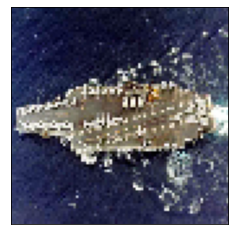

In [18]:
plt.imshow(train_images[0].astype(int))
plt.xticks([])
plt.yticks([])

Patching picture into 14 x 14 parts


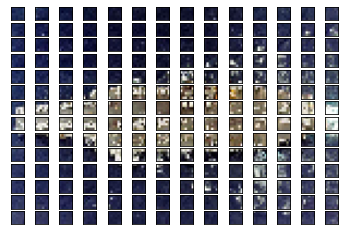

In [19]:
pic = train_images[:1]
PIL_pic = torch.zeros(1,3,84,84).to(DEVICE)
PIL_pic[0] = torchvision.transforms.Compose([
                                                      torchvision.transforms.ToPILImage(), 
                                                     torchvision.transforms.ToTensor()
                                                    ]) (pic[0])
p = Patches(patch_size = 6)
patches = p(PIL_pic)
patch = patches[0]
patch_row = int(np.sqrt(patch.shape[0]))
print(f'Patching picture into {patch_row } x {patch_row } parts')
for i in range(patch_row ):
    for j in range(patch_row ):

        plt.subplot( patch_row ,patch_row ,i*patch_row  + j + 1)
        plt.imshow(patch[i*patch_row  + j].cpu().numpy())
        plt.xticks([])
        plt.yticks([])

In [20]:
class DS(Dataset):
    def __init__(self,
                 data,
                 labels,
                 prob_labels,
                 transformation = None,
                 augmentation = None):
        
        '''
        здесь должен быть код инициализациия экземпляра класса DS
        В нем следует считать данные и записать в виде атрибутов этого экземпляра класса
        Также следует сохранить в качестве атрибута этого экземпляра класса преобразование(я) transform,
            которые должны будут применяться к данным
        
        '''
        self.augmentation = augmentation
        
        self.transformation  = transformation
        self.labels = labels
        self.prob_labels = prob_labels
        self.data =data
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        y_prob = self.prob_labels[index]
      
        x =  torchvision.transforms.Compose([
                                                      torchvision.transforms.ToPILImage(), 
                                                     torchvision.transforms.ToTensor()
                                                    ])(x)
        if(self.transformation):
            x = self.transformation (x)

        if(self.augmentation):
            x = self.augmentation(x)
  
        return x,y, y_prob
    

    def __len__(self):
        length = self.data.shape[0]
        return length

## Implement the patch encoding layer

Проецирует линейно на скрытое измерение и добавляет Positional Embedding

In [21]:

class PatchEncoder(nn.Module):
    def __init__(self, num_patches,patch_size, projection_dim,num_channels = 3, dropout = 0.1):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = nn.Linear(num_channels*patch_size**2, projection_dim)
        self.pos_embedding = nn.Embedding( num_patches, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([projection_dim])).to(DEVICE)
        self.num_channels = num_channels
    def forward(self, patch):
       
        unpack_shape = patch.shape
        patch = torch.flatten(patch, start_dim = 2)
        patch = torch.flatten(patch, end_dim = 1)
        patch = self.projection(patch)
        patch = nn.Unflatten(0, unpack_shape[:2])(patch)
        
        pos = torch.arange(0, self.num_patches).unsqueeze(0).repeat(patch.shape[0], 1).to(DEVICE)
        
        patch = self.dropout(patch/self.scale  + self.pos_embedding(pos))
        
        return patch


## ViT model

Трасформерные блоки используют Multiheadattention, как механизм запоминания картинок по патчам. 



In [22]:
class Transformer_Encoder_Layer(nn.Module):
    def __init__(self, num_heads, hid_dim,mlp_layers_dims, dropout = 0.1):
        super(Transformer_Encoder_Layer, self).__init__()
        self.num_heads = num_heads
        self.hid_dim = hid_dim
        
        self.norm_before_multihead = nn.LayerNorm(hid_dim)
        self.multihead = nn.MultiheadAttention(hid_dim, num_heads, dropout =dropout)
        self.norm_after_multihead = nn.LayerNorm(hid_dim)
        self.mlp = MLP(mlp_layers_dims).to(DEVICE)
        self.mlp.apply(init_weights)

    # Create multiple layers of the Transformer block.
    def forward(self, x):
        # Layer normalization 1.
        _x = x.clone()
        x = self.norm_before_multihead(x)
        # Create a multi-head attention layer.
        attention_output,_ = self.multihead(x,x,x)
        # Skip connection 1.
        x = _x + attention_output
        # Layer normalization 2.
        _x = x.clone()
        x = self.norm_after_multihead(x)
        # MLP.
        x = self.mlp.forward(x)
        # Skip connection 2.
        x  =_x + x
        return x


In [23]:
class VIT(nn.Module):
    def __init__(self, patch_size,num_patches,projection_dim,transformer_layers_config,mlp_head_layers_dim , num_channels = 3, start_head = False):
        super(VIT, self).__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.patch_size = patch_size
        self.num_channels = num_channels
        #дополнительная начальная CNN
        self.start_head = start_head
        if(self.start_head == True):
            
            self.start_CNN =  CNN().to(DEVICE)
        self.patches = Patches(patch_size, num_channels = num_channels)
        self.patch_encoding = PatchEncoder(num_patches, patch_size,projection_dim, num_channels = num_channels)
        self.transformer_layers = []
        for num_heads, config in transformer_layers_config:
            self.transformer_layers.append (Transformer_Encoder_Layer(num_heads, projection_dim,config ).to(DEVICE))
        self.final_representation= nn.Sequential(
            nn.LayerNorm( transformer_layers_config[-1][1][-1][1]),
            nn.Flatten(start_dim=1),
            nn.Dropout(0.5)
        )
        self.MLP_head = MLP(mlp_head_layers_dim ).to(DEVICE)
        self.MLP_head.apply(init_weights)

    def forward(self,x):
      if(self.start_head == True):
        x = self.start_CNN(x)

      x = self.patches(x)
      x = self.patch_encoding(x)
      for layer in self.transformer_layers:
            x = layer(x)
      x = self.final_representation(x)
      x = self.MLP_head(x)
      #log soft max устойчивей чем простой
      output = F.log_softmax(x, dim = 1)
      return output


## Compile, train, and evaluate the mode

In [24]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       train_loader,
                       data_len):
    
    model.train()
    loss_sum = 0
    accuracy = 0

    for x,y,y_prob in tqdm(train_loader):
        x = x.to(DEVICE)
        y_prob = y_prob.to(DEVICE)
        y = y.to(DEVICE)
        
        model.zero_grad()
        hyp = model(x)
       
        loss = loss_function(hyp, y_prob)
        loss.backward()
        loss_sum += loss
        
        optimizer.step()
        y_pred = hyp.argmax(dim = 1, keepdim = True).to(DEVICE)
        y_hat = y_prob.argmax(dim = 1, keepdim = True).to(DEVICE)
        accuracy += y_pred.eq(y_hat.view_as(y_pred)).sum().item()

    
    accuracy_avr = 100 * accuracy / float(data_len)
    
    return {'loss' : loss_sum.item()/float(data_len), 'accuracy' : accuracy_avr}
    
    

In [25]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,                          
                          test_loader,
                          data_len):
    model.eval()
    loss_sum = 0
    accuracy = 0
    
    for x,y,y_prob in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_prob = y_prob.to(DEVICE)

        

        hyp = model(x)
        loss = loss_function(hyp, y_prob)
        loss_sum += loss

        y_pred = hyp.argmax(dim = 1, keepdim = True).to(DEVICE)
        y_hat = y_prob.argmax(dim = 1, keepdim = True).to(DEVICE)
 
        accuracy += y_pred.eq(y_hat.view_as(y_pred)).sum().item()

    loss_avr = loss_sum / float(data_len)
    accuracy_avr = 100 * accuracy / float(data_len)
    
    return {'loss' : loss_avr.item(), 'accuracy' : accuracy_avr}

In [26]:
def train_model(model: torch.nn.Module, 
                train_data,
                train_labels,
                train_prob_labels,
                test_data,
                test_labels,
                test_prob_labels,
                augmentation,
                transformation,

                save_link,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.AdamW,
                optimizer_params: Dict = { 'betas':  (0.9, 0.999), 'eps' :1e-9 , 'weight_decay' : 1e-4  },
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 16,
                max_epochs = 1000,
                early_stopping_patience = 20):
    # set to training mode
 
    train_dataset = DS(train_data, train_labels,train_prob_labels, transformation, augmentation)

    test_dataset = DS(test_data, test_labels, test_prob_labels)


    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


    # Everything is ready for the training
  
    model.to(DEVICE)
    optimizer = optimizer_class(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    best_val_loss = None
    best_epoch = None
    loss_list = {'train': list(), 'valid': list()}
    

    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
    
        train_loss =  train_single_epoch(model, optimizer, loss_function,train_loader, len(train_dataset))
        print(f'Train metrics: \n{train_loss}')
        print('Validating epoch\n')

        val_metrics = validate_single_epoch(model, loss_function,test_loader, len(test_dataset))
        loss_list['valid'].append(val_metrics['loss'])
        loss_list['train'].append(train_loss['loss'])
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
         
           
            torch.save(model,save_link)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            ploting_curves(loss_list,best_epoch)
            break
    return model, loss_list 


##Model config

Здесь происходит обуение и настройка параметров, можете экспериментировать и пробовать разные штуки на дефолтной модели нейронки, крайне советую почитать статью и посмотреть на их параметры для обучения.

Можно менять такие вещи как: оптимизатор, расписание и значение learning rate, финальную MLP голову модели и количество голов в трансформере, размерность скрытого измерения. Так же можно изначально поставить CNN сеть и из её выходов делать патчи.

In [76]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
num_channels = 3
image_size = 84  
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64


Настройка стартовой головы

In [77]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.layer = nn.Sequential(nn.Conv2d(3, 4, 2), 
                                    nn.ReLU(),
                                    nn.Conv2d(4,8, 2,1),

                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=1)) 
        self.layer.apply(init_weights)
    def forward(self, x):
            return self.layer(x)

In [78]:
# проверить размерности выходного изображения
c =CNN()
new_patch_size = 3
# new_patch_size должен делиться на new_shape[2,3]
new_shape = c.forward(torch.Tensor(train_images[:3].transpose(0,3,1,2))).shape
print(new_shape)
new_num_patches = int(new_shape[2]/new_patch_size * new_shape[3]/new_patch_size)
new_num_channels = new_shape[1]
print(f'new num patches: {new_num_patches}' )

torch.Size([3, 8, 81, 81])
new num patches: 729


In [79]:
#здесь задаётся MLP в кадом слое трансформера
#один слой задётся tuple (кол-во голов в multiheadattention(должно быть делителем projection_dim) , list из слоёв в mlp первый и последний должны быть размерности projection_dim)
transformer_layers_config = [
                             (2,  [(projection_dim, 64), (64 ,128 ),(128 ,1024 ), (1024 ,2048 ), (2048, projection_dim)])
                             

                         ]
#тут задаётся только главная голова MLP
#Если сиспользуйте стартовую голову CNN не забудье поменять num_patches на new_num_patches
mlp_head_layers_dim = [(projection_dim*num_patches,256), (256,512) , (512,1024),(1024, 2048), ( 2048, num_classes)]


In [80]:
#если используйте стартовую CNN голову не забудьте поменять: patch_size , num_patches, num_channels на new_...
model = VIT(patch_size = patch_size, 
            num_patches = num_patches,
            projection_dim = projection_dim,
            transformer_layers_config = transformer_layers_config,
            mlp_head_layers_dim = mlp_head_layers_dim,
            num_channels=num_channels,
            start_head= False)
model.to(DEVICE)

VIT(
  (patches): Patches()
  (patch_encoding): PatchEncoder(
    (projection): Linear(in_features=48, out_features=128, bias=True)
    (pos_embedding): Embedding(441, 128)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (final_representation): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (MLP_head): MLP()
)

In [81]:
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters 62976


In [82]:
model.apply(init_weights)

VIT(
  (patches): Patches()
  (patch_encoding): PatchEncoder(
    (projection): Linear(in_features=48, out_features=128, bias=True)
    (pos_embedding): Embedding(441, 128)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (final_representation): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (MLP_head): MLP()
)

##Configure hyperparametrs

[Трансформации](https://pytorch.org/vision/stable/transforms.html)

In [83]:
#можете вертеть, отзеркаливать, вырезать части и блюрить картинки. Следите за тем, чтобы ответ при этом не менялся (например отзеркалить цифру 2 нельзя, это уже будет 5)
transformation  = torchvision.transforms.Compose([
                                      
])
#тоже самое, но это рфботает нестабильно, не используйте                                                ])
augmentation  =  iaa.Sequential([
                                  iaa.Fliplr(0.5), # horizontally flip 50% of the images
                                   iaa.GaussianBlur(sigma=(0, 3.0)),
                                   iaa.Flipud(0.5),
                                   iaa.Affine(rotate = (-30,30),scale=(0.5, 1.5))                                                    
                                  ])


[learning rate](https://)

In [86]:
#Это расписание learning rate с постепенным линейным нагревом, а потом убываением. Говорят, без него трансформер просто не обучить, так что обучайте на этом
initial_lr  = 0.8
warmup_epoch = 100
def lambda_lr (epoch):
    if(epoch <= warmup_epoch): 
        return initial_lr*(epoch+1) 
    else: 
        return   initial_lr/np.sqrt(epoch+1)

In [ ]:
best_model,loss_list = train_model(model, #cама модель 
                train_images,
                train_labels,
                train_prob_labels,
                test_images,
                test_labels,
                test_prob_labels,
                #Сюда забейте ссылку куда кидать моедли, обязательно их сохраняйте!!!!

                save_link =  '/content/drive/MyDrive/VIT_models/best_VIT_model.pth',
                #преобразование данных
                augmentation = None,
                transformation = transformation,
                #оптимизатор
                optimizer_class = torch.optim.AdamW,
                optimizer_params =  { 'betas':  (0.9, 0.999), 'eps' :1e-9 , 'weight_decay' : 1e-4  },
                #расписание learning rate
                lr_scheduler_class = torch.optim.lr_scheduler.MultiplicativeLR,
                lr_scheduler_params  = {'lr_lambda' : lambda_lr},
                
                batch_size = 256,
                initial_lr = initial_lr )

Epoch 0


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015965378284454344, 'accuracy': 4.462890625}
Validating epoch

Validation metrics: 
{'loss': 0.015927499160170555, 'accuracy': 5.377604166666667}
Best model yet, saving


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015960889061292012, 'accuracy': 4.684244791666667}
Validating epoch

Validation metrics: 
{'loss': 0.01591784879565239, 'accuracy': 5.325520833333333}
Best model yet, saving
Epoch 2


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015941808621088665, 'accuracy': 4.928385416666667}
Validating epoch

Validation metrics: 
{'loss': 0.01587606407701969, 'accuracy': 5.572916666666667}
Best model yet, saving
Epoch 3


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.0159143735965093, 'accuracy': 4.973958333333333}
Validating epoch

Validation metrics: 
{'loss': 0.015866253525018692, 'accuracy': 5.572916666666667}
Best model yet, saving
Epoch 4


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01590737303098043, 'accuracy': 5.120442708333333}
Validating epoch

Validation metrics: 
{'loss': 0.015841573476791382, 'accuracy': 5.872395833333333}
Best model yet, saving
Epoch 5


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015885817011197408, 'accuracy': 5.37109375}
Validating epoch

Validation metrics: 
{'loss': 0.01582339219748974, 'accuracy': 6.158854166666667}
Best model yet, saving
Epoch 6


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01587965488433838, 'accuracy': 5.41015625}
Validating epoch

Validation metrics: 
{'loss': 0.015827929601073265, 'accuracy': 6.041666666666667}
Epoch 7


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01587084631125132, 'accuracy': 5.458984375}
Validating epoch

Validation metrics: 
{'loss': 0.015808220952749252, 'accuracy': 6.028645833333333}
Best model yet, saving
Epoch 8


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01587120592594147, 'accuracy': 5.537109375}
Validating epoch

Validation metrics: 
{'loss': 0.015814749523997307, 'accuracy': 6.0546875}
Epoch 9


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015860092639923096, 'accuracy': 5.423177083333333}
Validating epoch

Validation metrics: 
{'loss': 0.015830030664801598, 'accuracy': 6.4453125}
Epoch 10


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015851587057113647, 'accuracy': 5.559895833333333}
Validating epoch

Validation metrics: 
{'loss': 0.015805279836058617, 'accuracy': 6.223958333333333}
Best model yet, saving
Epoch 11


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01585947573184967, 'accuracy': 5.530598958333333}
Validating epoch

Validation metrics: 
{'loss': 0.015814771875739098, 'accuracy': 6.354166666666667}
Epoch 12


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015838155150413515, 'accuracy': 5.576171875}
Validating epoch

Validation metrics: 
{'loss': 0.015794044360518456, 'accuracy': 6.40625}
Best model yet, saving
Epoch 13


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


Train metrics: 
{'loss': 0.015845500429471335, 'accuracy': 5.810546875}
Validating epoch

Validation metrics: 
{'loss': 0.015804573893547058, 'accuracy': 6.458333333333333}
Epoch 14


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015848740935325623, 'accuracy': 5.817057291666667}
Validating epoch

Validation metrics: 
{'loss': 0.01580016501247883, 'accuracy': 6.315104166666667}
Epoch 15


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01584445536136627, 'accuracy': 5.611979166666667}
Validating epoch

Validation metrics: 
{'loss': 0.01579110696911812, 'accuracy': 6.302083333333333}
Best model yet, saving
Epoch 16


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015840718150138856, 'accuracy': 5.810546875}
Validating epoch

Validation metrics: 
{'loss': 0.01578647829592228, 'accuracy': 6.536458333333333}
Best model yet, saving
Epoch 17


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015842348337173462, 'accuracy': 5.563151041666667}
Validating epoch

Validation metrics: 
{'loss': 0.0158018097281456, 'accuracy': 6.666666666666667}
Epoch 18


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


Train metrics: 
{'loss': 0.01583854655424754, 'accuracy': 5.755208333333333}
Validating epoch

Validation metrics: 
{'loss': 0.015778157860040665, 'accuracy': 6.588541666666667}
Best model yet, saving
Epoch 19


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


Train metrics: 
{'loss': 0.015853997071584067, 'accuracy': 5.764973958333333}
Validating epoch

Validation metrics: 
{'loss': 0.015808776021003723, 'accuracy': 6.119791666666667}
Epoch 20


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015838446219762166, 'accuracy': 5.885416666666667}
Validating epoch

Validation metrics: 
{'loss': 0.01580478623509407, 'accuracy': 5.885416666666667}
Epoch 21


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015827129284540813, 'accuracy': 5.823567708333333}
Validating epoch

Validation metrics: 
{'loss': 0.01579110510647297, 'accuracy': 6.380208333333333}
Epoch 22


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


Train metrics: 
{'loss': 0.015844156344731648, 'accuracy': 5.673828125}
Validating epoch

Validation metrics: 
{'loss': 0.01576792262494564, 'accuracy': 6.276041666666667}
Best model yet, saving
Epoch 23


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.015848197539647422, 'accuracy': 5.540364583333333}
Validating epoch

Validation metrics: 
{'loss': 0.015769517049193382, 'accuracy': 6.302083333333333}
Epoch 24


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


Train metrics: 
{'loss': 0.01583205759525299, 'accuracy': 5.738932291666667}
Validating epoch

Validation metrics: 
{'loss': 0.015792304649949074, 'accuracy': 6.484375}
Epoch 25


 83%|████████▎ | 100/120 [02:05<00:25,  1.26s/it]

##RESNET

Здесь я дропнул код модели Resnet типа CNN, которые очень хорошо зарекомендовали себя  в классификации изображений. Попробуйте по аналогии с кодом выше обучить как pretrained, так и с 0 эти модели и посмотрите, какая точность достигается за 200 эпох

In [36]:
class Pe_resnet512(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (84, 84),
                 input_channels: int = 3, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 64):
        
        super().__init__()

        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation
        self.num_classes = num_classes
        #pretrained будет перенасить уже хорошо обученные параметры в модель
        resnet152 = torchvision.models.resnet152(pretrained=False, progress=False)
        #тру - параметры модели будут обучаться, false -останутся как было
        for param in resnet152.parameters():
            param.requires_grad = True

        resnet152.fc = torch.nn.Sequential(torch.nn.Linear(2048, 128))

        self.layer = torch.nn.Sequential(resnet152,
                                         torch.nn.BatchNorm1d(128),
                                         torch.nn.ReLU(),
                                torch.nn.Linear(128,256),
                                torch.nn.BatchNorm1d(256),
                                torch.nn.ReLU(),
                                torch.nn.Linear(256,512),
                                torch.nn.BatchNorm1d(512),
                                torch.nn.ReLU(),
                                torch.nn.Linear(512,num_classes))
    
        
    def forward(self, x):
        
        x = self.layer(x)
        
        output = F.log_softmax(x, dim = 1)
        
        return output

In [37]:
pe_resnet = Pe_resnet512(num_classes= num_classes)

In [38]:
print('Total number of trainable parameters', 
      sum(p.numel() for p in pe_resnet.parameters() if p.requires_grad))

Total number of trainable parameters 461504


In [ ]:
best_model_resnet, loss_log_resnet = train_model(pe_resnet, #cама модель 
                train_images,
                train_labels,
                train_prob_labels,
                test_images,
                test_labels,
                test_prob_labels,
                save_link =  '/content/drive/MyDrive/VIT_models/best_resnet_model.pth',
                  #преобразование данных
                augmentation = None,
                transformation = transformation,
                #оптимизатор
                optimizer_class = torch.optim.AdamW,
                optimizer_params =  { 'betas':  (0.9, 0.999), 'eps' :1e-9 , 'weight_decay' : 1e-4  },
                #расписание learning rate
                lr_scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params  = {'patience' : 10, 'threshold': 1e-4},
                
                batch_size = 64,
                initial_lr = initial_lr )